# Score Normalization

Symmetric normalization (s-norm) with adapative cohort selection scheme followed by top score selection (top as-norm). 

[THE NEC-TT SPEAKER VERIFICATION SYSTEM FOR SRE18](https://irdb.nii.ac.jp/en/00897/0003998804)

> We use symmetric normalization (s-norm) with adaptive cohort selection scheme followed by top score selection (top as-norm). Let s_ij be the score for a given trial of speaker i on test segment j. Score normalization is performed on s_ij, such that

<img src="imgs/s-norm.png" alt="IMAGE ALT TEXT HERE" align="middle" width="240" border="1" /></a>

> Here, mu_i and omega_i are the mean and standard deviation of the scores by matching the speaker i against the cohort set omega_j. And this cohort set was selected based on the test segment j. Similarly for mu_j and omega_j, where the cohort set was selected based on the speaker i. The score normalization scheme is symmetric with respect to the speaker and test segment. It is also adaptive in terms of cohort selection. A final touch is the use of top N scores (instead of all cohort scores) in computing the mean and standard deviation.

[TOWARDS REDUCED FALSE-ALARMS USING COHORTS](https://groups.csail.mit.edu/sls/publications/2011/Dehak1_ICASSP2011.pdf)

> It is common for speaker verification systems to be followed by a
score normalization technique, the goal of which is to reduce within
trial variability leading to improved performance, better calibration,
and more reliable threshold setting. In this work symmetric score
normalization (SNorm) [5] is used as the baseline. For every scores s(utta, uttb) between two utterances, the corresponding SNorm score s'(utta, uttb) is

<img src="imgs/s-norm2.png" alt="IMAGE ALT TEXT HERE" width="300" border="1" /></a>


## Sources

[Unsupervised Speaker Adaptation based on the Cosine Similarity for
Text-Independent Speaker Verification](https://groups.csail.mit.edu/sls/publications/2010/Shum_Odyssey.pdf)

* T-Norm, Z-Norm, ZT-Norm, S-Norm, Normalized Cosine Similarity

[Improving Robustness of Speaker Recognition to New Conditions Using
Unlabeled Data](https://www.sri.com/sites/default/files/publications/improving_robustness_of_speaker_recognition_to_new_conditions_using.pdf)

* S-Norm, AS-Norm

[Analysis of Score Normalization in Multilingual Speaker Recognition](https://pdfs.semanticscholar.org/295b/4823f8baa9b8c8b24ae7d28875344062731b.pdf)

* T-Norm, Z-Norm, ZT-Norm, S-Norm, AS-Norm

[SPEAKER ADAPTIVE COHORT SELECTION FOR TNORM IN TEXT-INDEPENDENT
SPEAKER VERIFICATION](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.207.9879&rep=rep1&type=pdf)

* Normalizations

[Comparison of Speaker Recognition Approaches for Real Applications](https://core.ac.uk/download/pdf/11422064.pdf)

* Section 5


## 1.0 Preparation

In [1]:
import pandas as pd
import numpy as np
import os
from operator import itemgetter
from scipy.optimize import brentq
from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
DATA_PATH_v1 = '/Volumes/dfs/gen/Misc/data19/patx/alamja/sre19works/fusion_calibration/all_scores_with_keys'
# DATA_PATH = '/Volumes/dfs/gen/Misc/data19/patx/monteijo/scores_sre2019/cosine/aspp_pre'
DATA_PATH = '/Volumes/dfs/gen/Misc/scratch05/patx/alamja/sre19works/fusion_stuffs/final_to_olda_6oct2019/resnet_finetune_cosine'

## 2.0 Load Data
### 2.1 Load Dev/Eval/Cohort set

In [2]:
# Load initial scores with labels
dev_scores_labels = pd.read_csv(os.path.join(DATA_PATH_v1, 'js4_scores_sre19_dev_test_cmn2_adapt.txt'), sep=' ', header=None)
dev_scores_labels.columns = ['speaker', 'test', 'score', 'label']
dev_scores_labels = dev_scores_labels.replace({'nontarget': 0, 'target': 1})

# Load actual scores without labels
dev_scores = pd.read_csv(os.path.join(DATA_PATH, 'scores_sre19_dev_test_cmn2'), sep=" ", header=None)
dev_scores.columns = ['speaker', 'test', 'score']

# Labels are missing so we will join the labels from the initial scores
dev_scores = dev_scores.merge(dev_scores_labels[['speaker', 'test', 'label']], on=['speaker', 'test'])
dev_scores.shape
dev_scores.head()

(2063007, 4)

,speaker,test,score,label
0,1126_sre18,aagtkcwg_sre18,0.085028,0
1,1126_sre18,aajrmyry_sre18,-0.018268,0
2,1126_sre18,aakhofgi_sre18,-0.009253,0
3,1126_sre18,aarzomvy_sre18,0.168168,0
4,1126_sre18,aauabxxi_sre18,-0.080446,0


In [3]:
# eval_scores = pd.read_csv(os.path.join(DATA_PATH, 'js4_scores_sre19_eval_test_cmn2_adapt.txt'), sep=' ', header=None)
eval_scores = pd.read_csv(os.path.join(DATA_PATH, 'scores_sre19_eval_test_cmn2'), sep=' ', header=None)
eval_scores.columns = ['speaker', 'test', 'score']
eval_scores.shape
eval_scores.head()

(2688376, 3)

,speaker,test,score
0,1001_sre19,aajrhrbk_sre19,0.068052
1,1001_sre19,aanxznlm_sre19,0.405849
2,1001_sre19,aayuatag_sre19,0.066163
3,1001_sre19,abdabzqf_sre19,-0.144404
4,1001_sre19,abgkmkdd_sre19,-0.157966


In [4]:
# Load initial scores with labels
cohort_scores_labels = pd.read_csv(os.path.join(DATA_PATH_v1, 'js4_scores_sre18_cmn2_eval_test_adapt.txt'), sep=' ', header=None)
cohort_scores_labels.columns = ['speaker', 'test', 'score', 'label']
cohort_scores_labels = cohort_scores_labels.replace({'imp': 0, 'tgt': 1})

# Load actual scores without labels
cohort_scores = pd.read_csv(os.path.join(DATA_PATH, 'scores_sre18_cmn2_eval_test'), sep=' ', header=None)
cohort_scores.columns = ['speaker', 'test', 'score']

# Labels are missing so we will join the labels from the initial scores
cohort_scores = cohort_scores.merge(cohort_scores_labels[['speaker', 'test', 'label']], on=['speaker', 'test'])
cohort_scores.shape
cohort_scores.head()

(349685, 4)

,speaker,test,score,label
0,1131_sre18,aaeeiknb_sre18,-0.046336,0
1,1131_sre18,aaqclfew_sre18,-0.047197,0
2,1131_sre18,abmnegny_sre18,0.074063,0
3,1131_sre18,aboerwai_sre18,0.192172,0
4,1131_sre18,abwyevvm_sre18,-0.003415,0


In [81]:
len(set(dev_scores.speaker.unique()) & set(cohort_scores.speaker.unique()))

380

### 2.2 Preprocessing

* `cohort_scores` is a subset of `dev_scores`. Not all speakers in `dev_scores` are present in `cohort_scores`, therefore we have to filter out unecessary trials. 

* Also, some trials in `cohort_scores` are also in `dev_scores`.  We want to filter out those trials, because a cohort must contain trials of (speaker, test) never seen in the development set.

#### 2.2.1 For Z-Norm

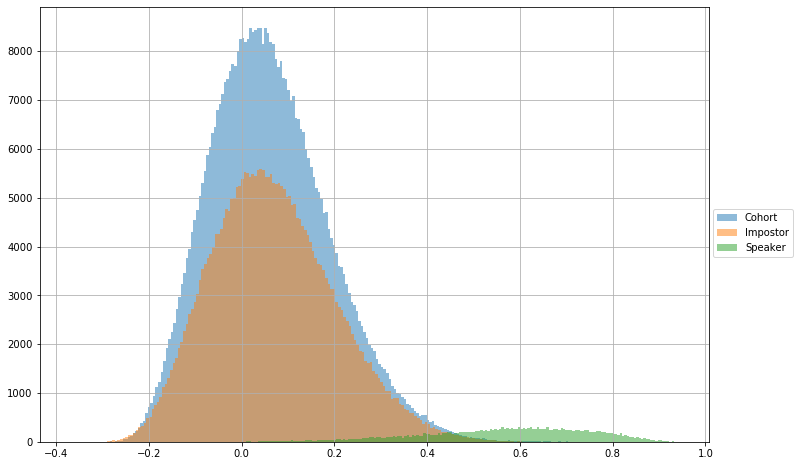

In [5]:
# Create column of tuple of trials
cohort_scores['trials'] = list(zip(cohort_scores.speaker, cohort_scores.test))
dev_scores['trials'] = list(zip(dev_scores.speaker, dev_scores.test))

# Look for trial matches in dev and cohort set
dev_scores['in_cohort'] = dev_scores.trials.isin(cohort_scores['trials'])

# Filter out speakers that weren't scored in the dev set
dev_scores_Z = dev_scores[dev_scores.speaker.isin(list(cohort_scores.speaker.unique()))]

# Example of result: if in_cohort is True, we keep this trial for the cohort set.
#                    if in_cohort is False, we keep this trial for the dev set.

# Recreate trials and cohort sets
# We use in_cohort=True as trials set because it has both 0 and 1 labels
# When in_cohort=False, trials only have labels=0
trials_Z = dev_scores_Z[dev_scores_Z.in_cohort]
cohort_Z = dev_scores_Z[~dev_scores_Z.in_cohort]
trials_Z.head(10)
cohort_Z.head(10)

fig = plt.figure(figsize=(12,8))
c = cohort_Z.score.hist(bins=200, alpha=0.5, label='Cohort')
t0 = trials_Z[trials_Z.label==0].score.hist(bins=200, alpha=0.5, label='Impostor')
t1 = trials_Z[trials_Z.label==1].score.hist(bins=200, alpha=0.5, label='Speaker')
fig.legend(loc='right');

#### 2.2.1 For T-Norm

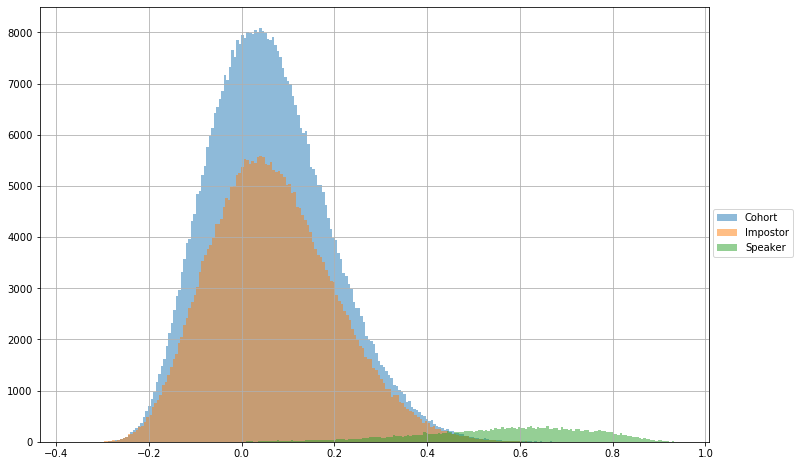

In [6]:
# Create column of tuple of trials
cohort_scores['test_utt'] = list(zip(cohort_scores.test, cohort_scores.speaker))
dev_scores['test_utt'] = list(zip(dev_scores.test, dev_scores.speaker))

# Look for trial matches in dev and cohort set
dev_scores['in_cohort'] = dev_scores.test_utt.isin(cohort_scores['test_utt'])

# Filter out test utterances that weren't scored in the dev set
dev_scores_T = dev_scores[dev_scores.test.isin(list(cohort_scores.test.unique()))]

# Example of result: if in_cohort is True, we keep this trial for the cohort set.
#                    if in_cohort is False, we keep this trial for the dev set.

# Recreate trials and cohort sets
# We use in_cohort=True as trials set because it has both 0 and 1 labels
# When in_cohort=False, trials only have labels=0
trials_T = dev_scores_T[dev_scores_T.in_cohort]
cohort_T = dev_scores_T[~dev_scores_T.in_cohort]
trials_T.head(10)
cohort_T.head(10)

fig = plt.figure(figsize=(12,8))
c = cohort_T.score.hist(bins=200, alpha=0.5, label='Cohort')
t0 = trials_T[trials_T.label==0].score.hist(bins=200, alpha=0.5, label='Impostor')
t1 = trials_T[trials_T.label==1].score.hist(bins=200, alpha=0.5, label='Speaker')
fig.legend(loc='right');

## 3.0 Score Normalization Techniques

**Impostors include the target even though it is not the enrollment? Or we remove those?**

* From [Analysis of Score Normalization in Multilingual Speaker Recognition] cohort E = {εi, ...}N with N speakers which we assume to be different from the speakers in enrollment utterance e and test utterance t.

**How to get better results?**

* From [Analysis of Score Normalization in Multilingual Speaker Recognition], when designing the cohort set on data without speaker labels, it is better to run unsupervised speaker clustering [31] and take only one file from each cluster. When selecting the cohort scores, it is also advantageous to eliminate/reject outlier scores by setting a ”safe” interval from minus to plus 4-5 times standard deviation around the mean, and reject all cohort data outside.


In [7]:
def calculate_eer(y, y_score, pos):
# y denotes groundtruth scores,
# y_score denotes the prediction scores.

    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=pos)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)

    return eer, thresh, fpr, tpr

# Creates a list of false-negative rates, a list of false-positive rates
# and a list of decision thresholds that give those error-rates.
def ComputeErrorRates(scores, labels):

    # Sort the scores from smallest to largest, and also get the corresponding
    # indexes of the sorted scores.  We will treat the sorted scores as the
    # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
        [(index, threshold) for index, threshold in enumerate(scores)],
        key=itemgetter(1)))
    sorted_labels = []
    labels = [labels[i] for i in sorted_indexes]
    fnrs = []
    fprs = []

    # At the end of this loop, fnrs[i] is the number of errors made by
    # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
    # is the total number of times that we have correctly accepted scores
    # greater than thresholds[i].
    for i in range(0, len(labels)):
        if i == 0:
            fnrs.append(labels[i])
            fprs.append(1 - labels[i])
        else:
            fnrs.append(fnrs[i-1] + labels[i])
            fprs.append(fprs[i-1] + 1 - labels[i])
    fnrs_norm = sum(labels)
    fprs_norm = len(labels) - fnrs_norm

    # Now divide by the total number of false negative errors to
    # obtain the false positive rates across all thresholds
    fnrs = [x / float(fnrs_norm) for x in fnrs]

    # Divide by the total number of corret positives to get the
    # true positive rate.  Subtract these quantities from 1 to
    # get the false positive rates.
    fprs = [1 - x / float(fprs_norm) for x in fprs]
    return fnrs, fprs, thresholds

# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa):
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

### 3.0 No norm


In [8]:
# Initialize Metrics
metrics = {}

In [9]:
eer, thresh, fpr, tpr = calculate_eer(trials_Z.label, trials_Z.score, pos=1)
print('EER : %.2f%%'%(eer*100))

EER : 6.92%


In [10]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(trials_Z.score.reset_index(drop=True), 
                                           trials_Z.label.reset_index(drop=True))
mindcf, threshold_default = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold_default, p_target,c_miss, c_fa))

minDCF : 0.3381, at threshold 0.4637 (p-target=0.05, c-miss=1, c-fa=1)


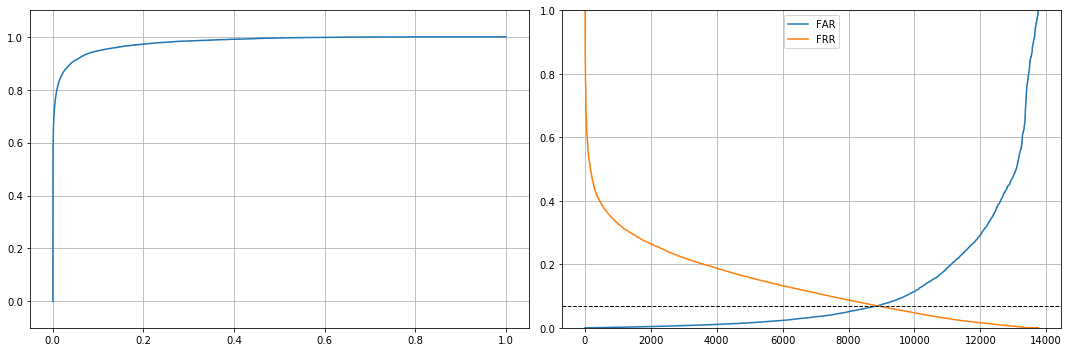

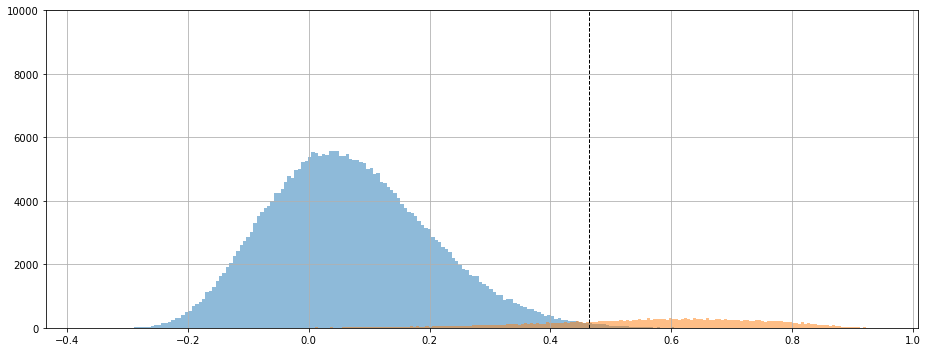

In [11]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(13,5))
fig = plt.subplot(111)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [12]:
metrics['No-Norm'] = {'EER': eer, 'minDCF': mindcf}

### 3.1 Z-Norm

In [13]:
def Z_Norm(trials, speaker_id='all'):
    '''
    The purpose of zero normalization (Z-norm) is to scale and shift the distribution 
    of scores between a target speaker w'_s and a set of impostor utterances I 
    to the standard normal distribution.
    
    TODO: Use all trials or just trials which are non-target?
    '''
    
    if speaker_id is not 'all':
        # Split trials
        speaker_trials = trials[trials.speaker == speaker_id]

        # Compute the mean
        speaker_trials_mean = np.mean(speaker_trials.score)

        # Compute standard deviation
        speaker_trials_std = np.std(speaker_trials.score)

        # Normalize scores
        speaker_trials_znorm = (speaker_trials.score - speaker_trials_mean) / speaker_trials_std
        
        # To dataframe
        speaker_trials['normalized_score'] = speaker_trials_znorm
        
    else:
        all_scores = []
        for ids in trials.speaker.unique():
            # Split trials
            speaker_trials = trials[trials.speaker == ids]

            # Compute the mean
            speaker_trials_mean = np.mean(speaker_trials.score)

            # Compute standard deviation
            speaker_trials_std = np.std(speaker_trials.score)

            # Normalize scores
            speaker_trials_znorm = (speaker_trials.score - speaker_trials_mean) / speaker_trials_std
            
            # To dataframe
            speaker_trials['normalized_score'] = list(speaker_trials_znorm)
            all_scores.append(speaker_trials)
            
        speaker_trials = pd.concat(all_scores)
    
    return speaker_trials

In [14]:
def Z_Norm2(trials, cohort):
    '''
    The purpose of zero normalization (Z-norm) is to scale and shift the distribution 
    of scores between a target speaker w'_s and a set of impostor utterances I 
    to the standard normal distribution.
    '''
    
    all_scores = []
    for ids in trials.speaker.unique():
        # Split cohort
        speaker_cohort = cohort[cohort.speaker == ids]
        speaker_trials = trials[trials.speaker == ids]

        # Compute the mean
        speaker_cohort_mean = np.mean(speaker_cohort.score)

        # Compute standard deviation
        speaker_cohort_std = np.std(speaker_cohort.score)

        # Normalize scores
        speaker_trials_znorm = (speaker_trials.score - speaker_cohort_mean) / speaker_cohort_std
        
        # To dataframe
        speaker_trials['normalized_score'] = list(speaker_trials_znorm)
        all_scores.append(speaker_trials)
        
    speaker_trials = pd.concat(all_scores)
    
    return speaker_trials

In [15]:
def A_Norm(trials, cohort, file, top=-1):
    '''
    The purpose of zero normalization (Z-norm) is to scale and shift the distribution 
    of scores between a target speaker w'_s and a set of impostor utterances I 
    to the standard normal distribution.
    
    In adaptive T-norm or Top-norm, only part of the cohort is selected
    to compute mean and variance for normalization. Usually X top scoring or 
    most similar files, where X is set to be for example 200.
    '''
    # Group by test_ID and keep top X scores
    if top > 0:
        c = cohort.sort_values([file, 'score'], ascending=False).groupby(file).head(top)
    else:
        c = cohort.sort_values([file, 'score'], ascending=False)

    # Get the mean/std of each test_ID adaptive cohort
    c_mean = c.groupby(file).agg({'score': np.mean})
    c_std = c.groupby(file).agg({'score': np.std})

    # Normalize
    trials = trials.join(c_mean, on=file, rsuffix='_mean')
    trials = trials.join(c_std, on=file, rsuffix='_std')
    trials['normalized_score'] = (trials['score'] - trials['score_mean']) / trials['score_std']
    return trials

In [16]:
znorm = A_Norm(trials_Z, cohort_Z, 'speaker')
eer, thresh, fpr, tpr = calculate_eer(znorm.label, znorm.normalized_score, pos=1)
znorm.to_pickle('./znorm.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 7.18%


In [17]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(znorm.normalized_score.reset_index(drop=True), 
                                           znorm.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3438, at threshold 3.1622 (p-target=0.05, c-miss=1, c-fa=1)


In [18]:
# plt.figure(figsize=(10,10))
# fig = plt.subplot(311)
# plt.plot(fpr,tpr)

# fig = plt.subplot(312)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(313)
# znorm[znorm.label == 0]['normalized_score'].hist(bins=200)
# znorm[znorm.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-4,8);

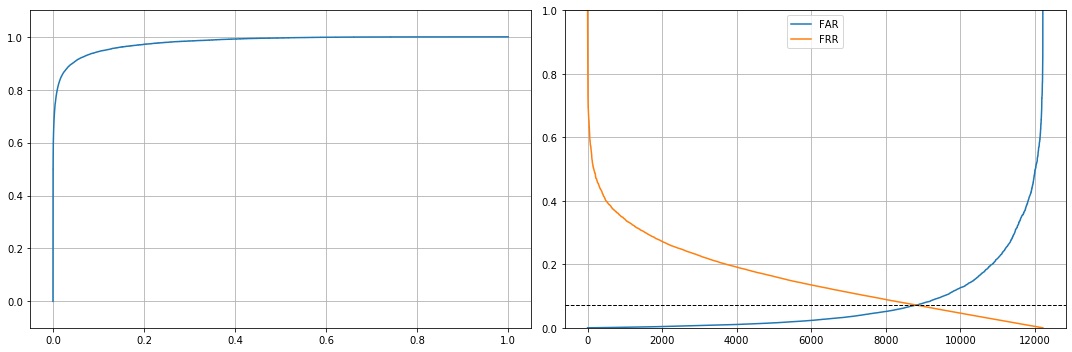

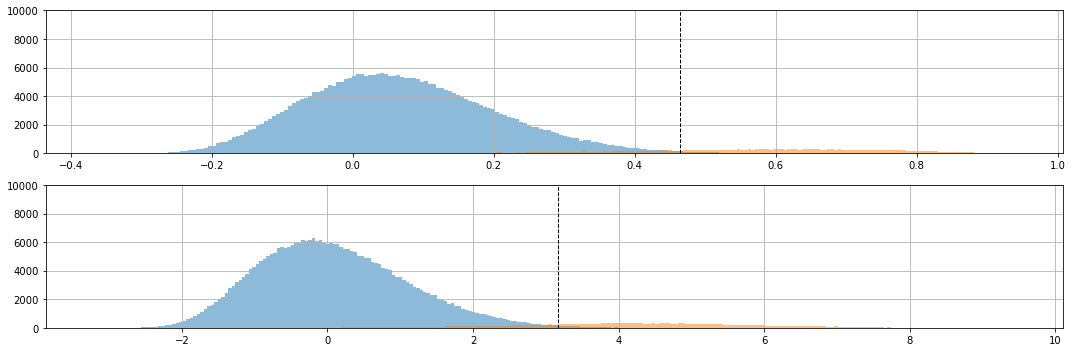

In [19]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
znorm[znorm.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
znorm[znorm.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [20]:
metrics['Z-Norm'] = {'EER': eer, 'minDCF': mindcf}

### 3.2 T-Norm

In [21]:
def T_Norm(trials, test_id='all'):
    '''
    Test score normalization is similar to Z-norm with the difference that it normalizes 
    the impostor score distribution for the test utterance. 
    
    TODO: Use all trials or just trials which are non-target?
    '''
    
    if test_id is not 'all':
        # Split trials
        test_trials = trials[trials.test == test_id]

        # Compute the mean
        test_trials_mean = np.mean(test_trials.score)

        # Compute standard deviation
        test_trials_std = np.std(test_trials.score)

        # Normalize scores
        test_trials_znorm = (test_trials.score - test_trials_mean) / test_trials_std
        
        # To dataframe
        test_trials['normalized_score'] = test_trials_znorm
        
    else:
        all_scores = []
        i=0
        for ids in trials.test.unique():
            if i%100==0:
                print(i)
            # Split trials
            test_trials = trials[trials.test == ids]

            # Compute the mean
            test_trials_mean = np.mean(test_trials.score)

            # Compute standard deviation
            test_trials_std = np.std(test_trials.score)

            # Normalize scores
            test_trials_znorm = (test_trials.score - test_trials_mean) / test_trials_std
            
            # To dataframe
            test_trials['normalized_score'] = list(test_trials_znorm)
            all_scores.append(test_trials)
            i+=1
            
        test_trials = pd.concat(all_scores)
    
    return test_trials

In [22]:
def T_Norm2(trials, cohort):
    '''
    Test score normalization is similar to Z-norm with the difference that it normalizes 
    the impostor score distribution for the test utterance. 
    '''
    
    all_scores = []
    i=0
    for ids in trials.test.unique():
        if i%100==0:
            print(i)
        # Split cohort
        test_cohort = cohort[cohort.test == ids]
        test_trials = trials[trials.test == ids]

        # Compute the mean
        test_cohort_mean = np.mean(test_cohort.score)

        # Compute standard deviation
        test_cohort_std = np.std(test_cohort.score)

        # Normalize scores
        test_trials_znorm = (test_trials.score - test_cohort_mean) / test_cohort_std
        
        # To dataframe
        test_trials['normalized_score'] = list(test_trials_znorm)
        all_scores.append(test_trials)
        i+=1
        
    test_trials = pd.concat(all_scores)
    
    return test_trials

In [23]:
tnorm = A_Norm(trials_T, cohort_T, 'test')
eer, thresh, fpr, tpr = calculate_eer(tnorm.label, tnorm.normalized_score, pos=1)
tnorm.to_pickle('./tnorm.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 7.03%


In [24]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(tnorm.normalized_score.reset_index(drop=True), 
                                           tnorm.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3569, at threshold 3.1648 (p-target=0.05, c-miss=1, c-fa=1)


In [25]:
# plt.figure(figsize=(10,10))
# fig = plt.subplot(311)
# plt.plot(fpr,tpr)

# fig = plt.subplot(312)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(313)
# tnorm[tnorm.label == 0]['normalized_score'].hist(bins=200)
# tnorm[tnorm.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-4,8);

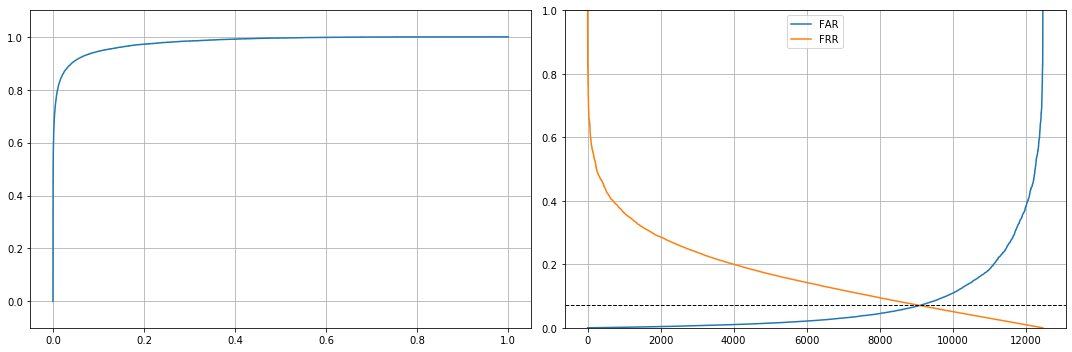

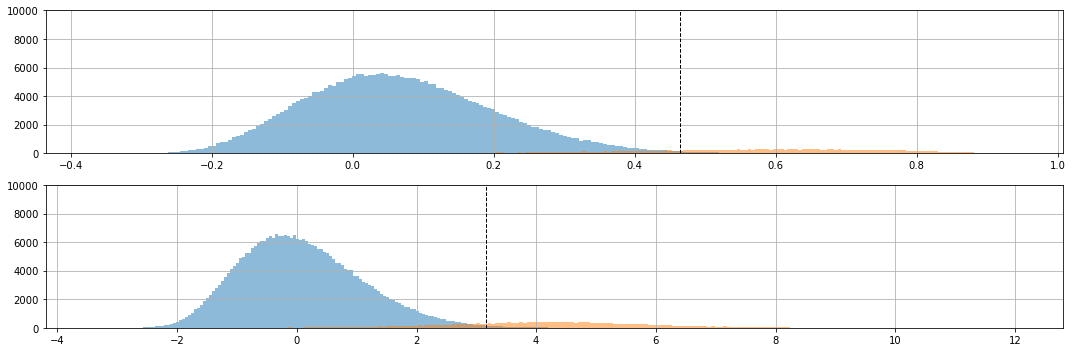

In [26]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
tnorm[tnorm.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
tnorm[tnorm.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [27]:
metrics['T-Norm'] = {'EER': eer, 'minDCF': mindcf}

### 3.3 ZT-Norm

In [28]:
def ZT_Norm(trials, cohort_s, cohort_t, top=-1):
    '''
    ZT-norm or TZ-norm use Z- and T-norm in series, and might
    use different cohorts for each step. By doing this, the
    scores are normalized with respect to both enrollment and test
    utterances.
    '''
    # Perform Z-Norm and update scores
    print('Computing z-norm...')
    znorm = A_Norm(trials, cohort_s, 'speaker', top)
    znorm['score'] = znorm['normalized_score']
    znorm = znorm[['speaker', 'test', 'score', 'label', 'trials', 'in_cohort']]
    
    # Perform T-Norm on z-normalized scores
    print('Computing t-norm...')
    ztnorm = A_Norm(znorm, cohort_t, 'test', top)
    
    print('zt-norm complete!')
    return ztnorm

In [29]:
ztnorm = ZT_Norm(trials_Z, cohort_Z, cohort_T)
eer, thresh, fpr, tpr = calculate_eer(ztnorm.label, ztnorm.normalized_score, pos=1)
ztnorm.to_pickle('./ztnorm.pkl')
print('EER : %.2f%%'%(eer*100))

Computing z-norm...
Computing t-norm...
zt-norm complete!
EER : 6.98%


In [30]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(ztnorm.normalized_score.reset_index(drop=True), 
                                           ztnorm.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3868, at threshold 25.5159 (p-target=0.05, c-miss=1, c-fa=1)


In [31]:
# plt.figure(figsize=(10,8))
# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# ztnorm[ztnorm.label == 0]['normalized_score'].hist(bins=200)
# ztnorm[ztnorm.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-4,8);

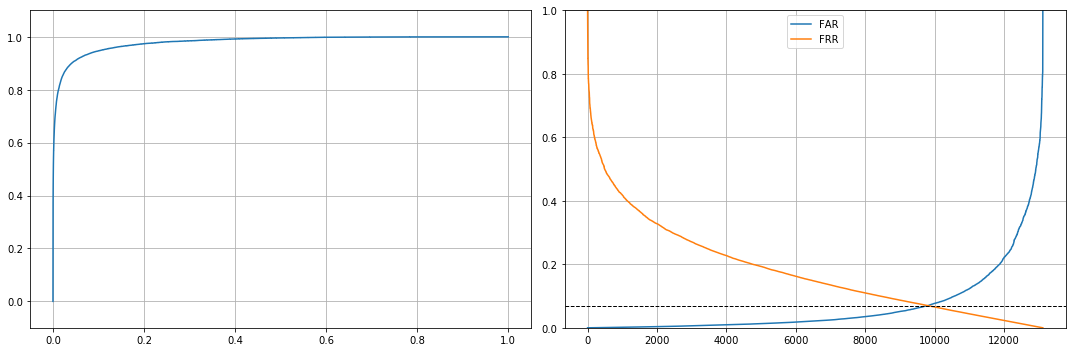

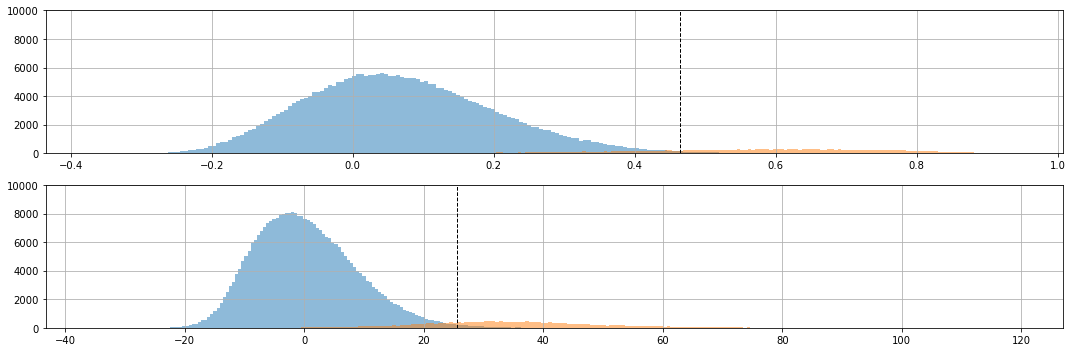

In [32]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
ztnorm[ztnorm.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
ztnorm[ztnorm.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [33]:
metrics['ZT-Norm'] = {'EER': eer, 'minDCF': mindcf}

In [34]:
def ZT_Norm(trials, test_id='all'):
    '''
    ZT-norm or TZ-norm use Z- and T-norm in series, and might
    use different cohorts for each step. By doing this, the
    scores are normalized with respect to both enrollment and test
    utterances.
    '''
    
    if test_id is not 'all':
        # Perform Z-Norm and update scores
        print('Computing z-norm...')
        znorm_trials = Z_Norm(trials, test_id)
        znorm_trials['score'] = znorm_trials['normalized_score']
        
        # Perform T-Norm on z-normalized scores
        print('Computing t-norm...')
        ztnorm_trials = T_Norm(znorm_trials, test_id)
        
    else:
        # Perform Z-Norm and update scores
        print('Computing z-norm...')
        znorm_trials = Z_Norm(trials)
        znorm_trials['score'] = znorm_trials['normalized_score']
        
        # Perform T-Norm on z-normalized scores
        print('Computing t-norm...')
        ztnorm_trials = T_Norm(znorm_trials)
    
    print('zt-norm complete!')
    return ztnorm_trials

In [35]:
def ZT_Norm2(trials_Z, cohort_Z, cohort_T):
    '''
    ZT-norm or TZ-norm use Z- and T-norm in series, and might
    use different cohorts for each step. By doing this, the
    scores are normalized with respect to both enrollment and test
    utterances.
    '''

    # Perform Z-Norm and update scores
    print('Computing z-norm...')
    znorm_trials = Z_Norm2(trials_Z, cohort_Z)
    znorm_trials['score'] = znorm_trials['normalized_score']
    
    # Perform T-Norm on z-normalized scores
    print('Computing t-norm...')
    ztnorm_trials = T_Norm2(znorm_trials, cohort_T)
    
    print('zt-norm complete!')
    return ztnorm_trials

### 3.4 S-Norm

In [36]:
def S_Norm(trials, znorm, tnorm):
    '''
    The symmetric normalization (S-norm) computes an average of
    normalized scores from Z-norm and T-norm. S-norm is
    symmetrical as s(e, t) = s(t, e), while the previously mentioned 
    normalizations depend on the order of e and t.
    '''
    # Check if trials are the same in znorm and tnorm
    znorm.sort_values('trials', inplace=True)
    tnorm.sort_values('trials', inplace=True)
    assert all(znorm['trials']) == all(tnorm['trials'])
    
    # Compute average of normalized scores from Z-norm and T-norm
    trials['normalized_score'] = (znorm['normalized_score'] + tnorm['normalized_score'])/2
    
    return trials

In [37]:
snorm = S_Norm(trials_Z, znorm, tnorm)
eer, thresh, fpr, tpr = calculate_eer(snorm.label, snorm.normalized_score, pos=1)
snorm.to_pickle('./snorm.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 6.97%


In [38]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(snorm.normalized_score.reset_index(drop=True), 
                                           snorm.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3346, at threshold 3.1260 (p-target=0.05, c-miss=1, c-fa=1)


In [39]:
# plt.figure(figsize=(10,8))
# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# snorm[snorm.label == 0]['normalized_score'].hist(bins=200)
# snorm[snorm.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-4,8);

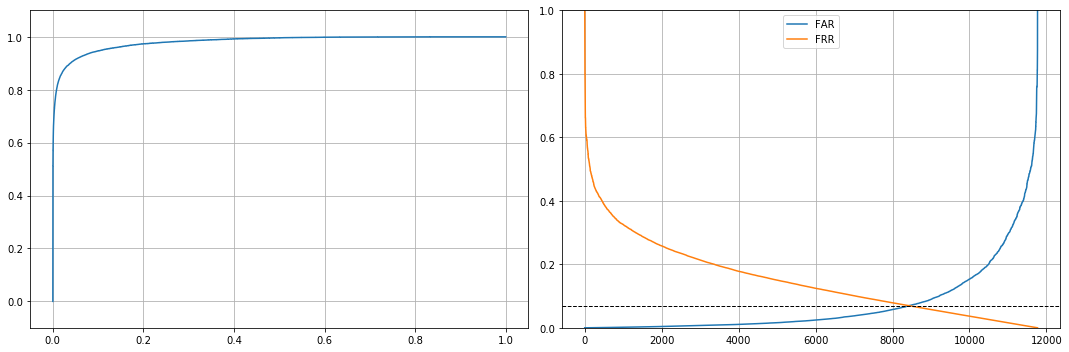

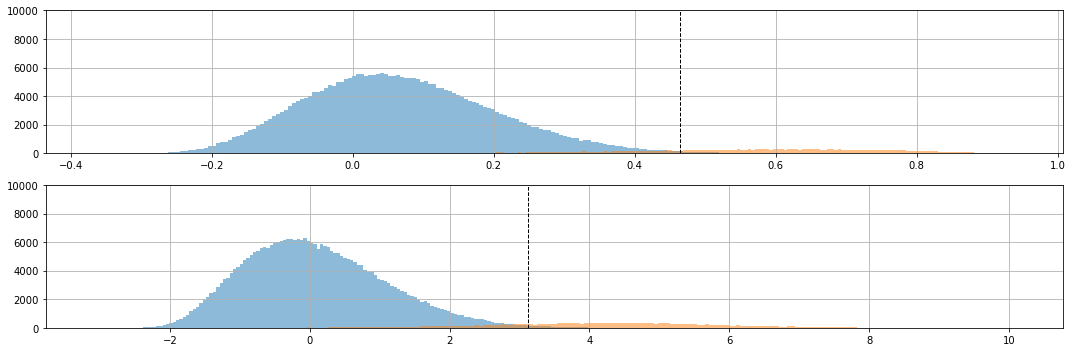

In [40]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
snorm[snorm.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
snorm[snorm.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [41]:
metrics['S-Norm'] = {'EER': eer, 'minDCF': mindcf}

### 3.5 AZ-Norm

In [42]:
# def A_Norm(trials, cohort, top=200, file='speaker'):
#     '''
#     The purpose of zero normalization (Z-norm) is to scale and shift the distribution 
#     of scores between a target speaker w'_s and a set of impostor utterances I 
#     to the standard normal distribution.
    
#     In adaptive T-norm or Top-norm, only part of the cohort is selected
#     to compute mean and variance for normalization. Usually X top scoring or 
#     most similar files, where X is set to be for example 200.
#     '''
#     if file == 'test':
#         test_top_cohort = {}
#         i=0
#         for test in trials.test.unique():
#             if i%100==0:
#                 print(i)
#             # Split cohort
#             test_cohort = cohort[cohort.test == test]

#             # Keep most similar impostors, based on score
#             '''TODO: top=200 is too high, number of trials is around 100 per test utterance'''
#             test_cohort = test_cohort.sort_values('score', ascending=False)
#             test_cohort = test_cohort.head(top)
#             test_top_cohort[test] = test_cohort
#             i+=1
        
#     if file == 'speaker':
#         enroll_top_cohort = {}
#         for enroll in trials.speaker.unique():
#             # Split cohort
#             speaker_cohort = cohort[cohort.speaker == enroll]

#             # Keep most similar impostors, based on score
#             speaker_cohort = speaker_cohort.sort_values('score', ascending=False)
#             speaker_cohort = speaker_cohort.head(top)
#             enroll_top_cohort[enroll] = speaker_cohort
        
#     all_scores = []
#     for index, row in trials.iterrows():
#         # Get correct adaptive cohort
#         e, t = row['trials']
#         if file is 'speaker':
#             cohort_scores = enroll_top_cohort[e]
#         elif file is 'test':
#             cohort_scores = test_top_cohort[t]
            
#         # Compute the mean
#         cohort_scores_mean = np.mean(cohort_scores.score)

#         # Compute standard deviation
#         cohort_scores_std = np.std(cohort_scores.score)
        
#         # Normalize scores
#         score_norm = (row['score'] - cohort_scores_mean) / cohort_scores_std
#         row['normalized_score'] = score_norm

#         # To dataframe
#         all_scores.append(pd.DataFrame(row).T)         
            
#     speaker_trials = pd.concat(all_scores)
#     speaker_trials.label = speaker_trials.label.astype(int)
#     speaker_trials.normalized_score = speaker_trials.normalized_score.astype(float)
#     return speaker_trials

#### 3.5.1 AZ-Norm, top enrollment files

In [43]:
%%time
aznorm_s = A_Norm(trials_Z, cohort_Z, 'speaker', top=100)
eer, thresh, fpr, tpr = calculate_eer(aznorm_s.label, aznorm_s.normalized_score, pos=1)
aznorm_s.to_pickle('./aznorm_s.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 6.98%
CPU times: user 751 ms, sys: 135 ms, total: 886 ms
Wall time: 900 ms


In [44]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(aznorm_s.normalized_score.reset_index(drop=True), 
                                           aznorm_s.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3642, at threshold 2.3773 (p-target=0.05, c-miss=1, c-fa=1)


In [45]:
# plt.figure(figsize=(10,10))

# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# aznorm_s[aznorm_s.label == 0]['normalized_score'].hist(bins=200)
# aznorm_s[aznorm_s.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-14,14);

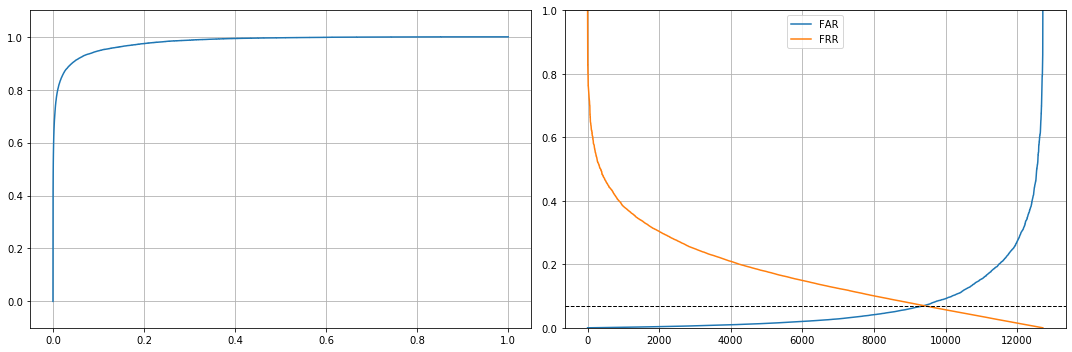

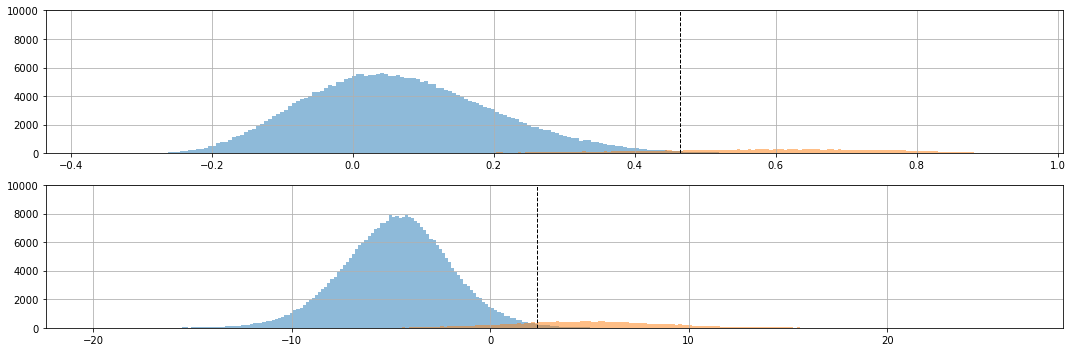

In [46]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
aznorm_s[aznorm_s.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
aznorm_s[aznorm_s.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [47]:
metrics['AZ-Norm-S_enroll'] = {'EER': eer, 'minDCF': mindcf}

#### 3.5.2 AZ-Norm, top test files

In [48]:
%%time
aznorm_t = A_Norm(trials_Z, cohort_T, 'test', top=100)
eer, thresh, fpr, tpr = calculate_eer(aznorm_t.label, aznorm_t.normalized_score, pos=1)
aznorm_t.to_pickle('./aznorm_t.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 7.03%
CPU times: user 991 ms, sys: 149 ms, total: 1.14 s
Wall time: 1.16 s


In [49]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(aznorm_t.normalized_score.reset_index(drop=True), 
                                           aznorm_t.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3621, at threshold 3.3173 (p-target=0.05, c-miss=1, c-fa=1)


In [50]:
# plt.figure(figsize=(10,10))

# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# aznorm_t[aznorm_t.label == 0]['normalized_score'].hist(bins=200)
# aznorm_t[aznorm_t.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-14,14);

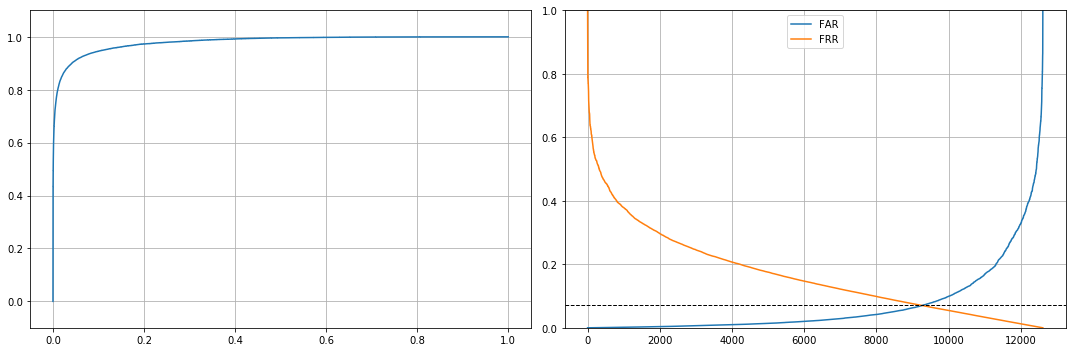

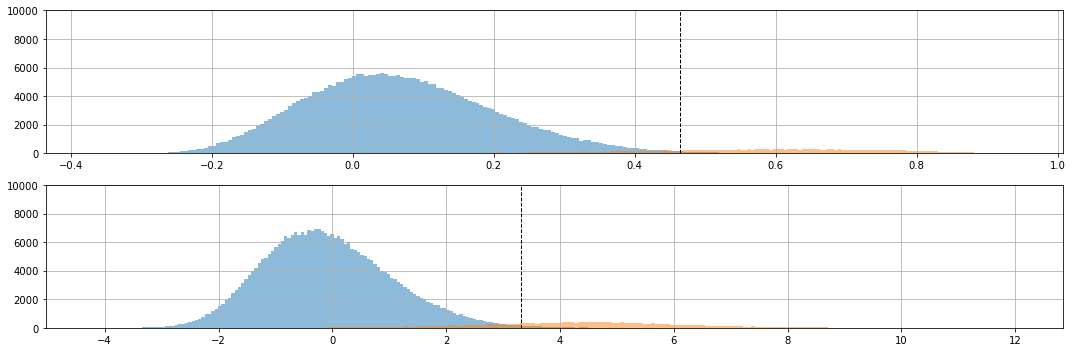

In [51]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
aznorm_t[aznorm_t.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
aznorm_t[aznorm_t.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [52]:
metrics['AZ-Norm-T_enroll'] = {'EER': eer, 'minDCF': mindcf}

### 3.6 AT-Norm

#### 3.6.1 AT-Norm, top test files

In [53]:
%%time
atnorm_t = A_Norm(trials_T, cohort_T, 'test', top=100)
eer, thresh, fpr, tpr = calculate_eer(atnorm_t.label, atnorm_t.normalized_score, pos=1)
atnorm_t.to_pickle('./atnorm_t.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 7.03%
CPU times: user 1.18 s, sys: 173 ms, total: 1.35 s
Wall time: 1.42 s


In [54]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(atnorm_t.normalized_score.reset_index(drop=True), 
                                           atnorm_t.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3621, at threshold 3.3173 (p-target=0.05, c-miss=1, c-fa=1)


In [55]:
# plt.figure(figsize=(10,10))

# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# atnorm_t[atnorm_t.label == 0]['normalized_score'].hist(bins=200)
# atnorm_t[atnorm_t.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-14,14);

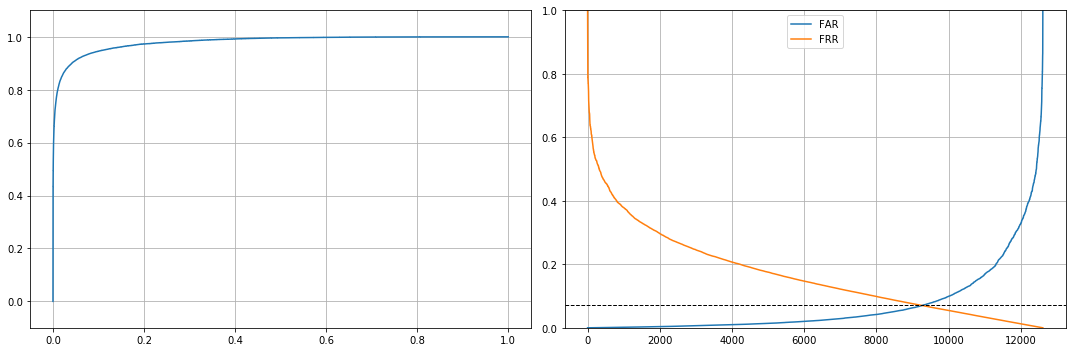

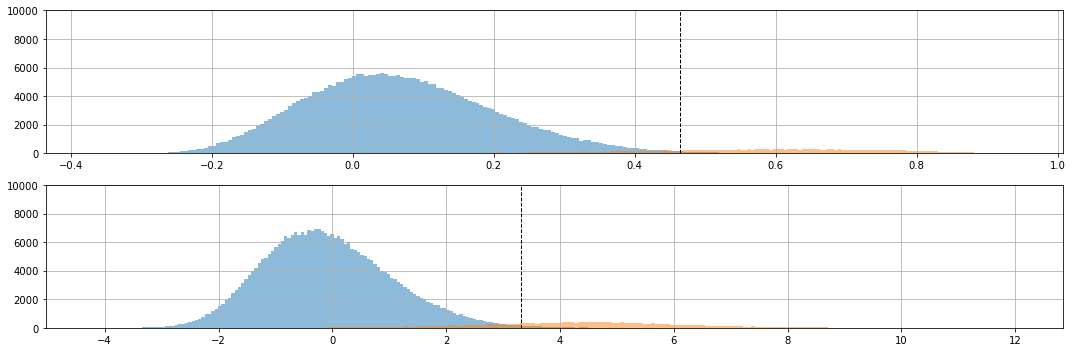

In [56]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
aznorm_t[aznorm_t.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
aznorm_t[aznorm_t.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [57]:
metrics['AT-Norm-t_enroll'] = {'EER': eer, 'minDCF': mindcf}

#### 3.6.2 AT-Norm, top enrollment files

In [58]:
%%time
atnorm_s = A_Norm(trials_T, cohort_Z, 'speaker', top=100)
eer, thresh, fpr, tpr = calculate_eer(atnorm_s.label, atnorm_s.normalized_score, pos=1)
atnorm_s.to_pickle('./atnorm_s.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 6.98%
CPU times: user 895 ms, sys: 156 ms, total: 1.05 s
Wall time: 1.07 s


In [59]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(atnorm_s.normalized_score.reset_index(drop=True), 
                                           atnorm_s.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3642, at threshold 2.3773 (p-target=0.05, c-miss=1, c-fa=1)


In [60]:
# plt.figure(figsize=(10,10))

# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# atnorm_s[atnorm_s.label == 0]['normalized_score'].hist(bins=200)
# atnorm_s[atnorm_s.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-14,14);

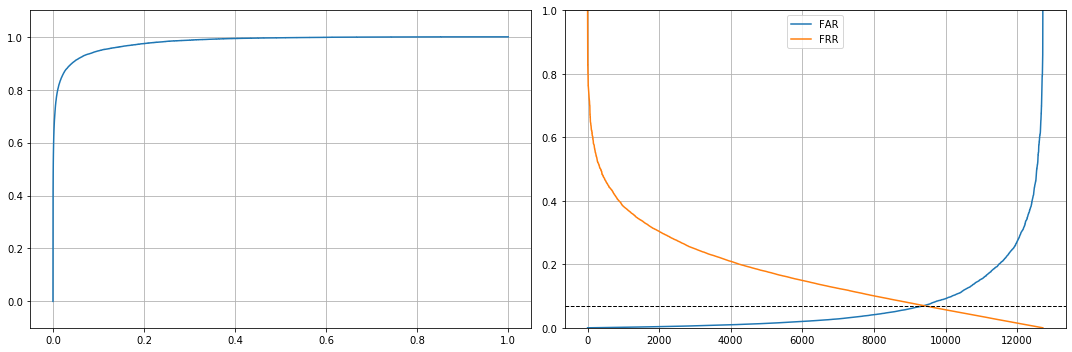

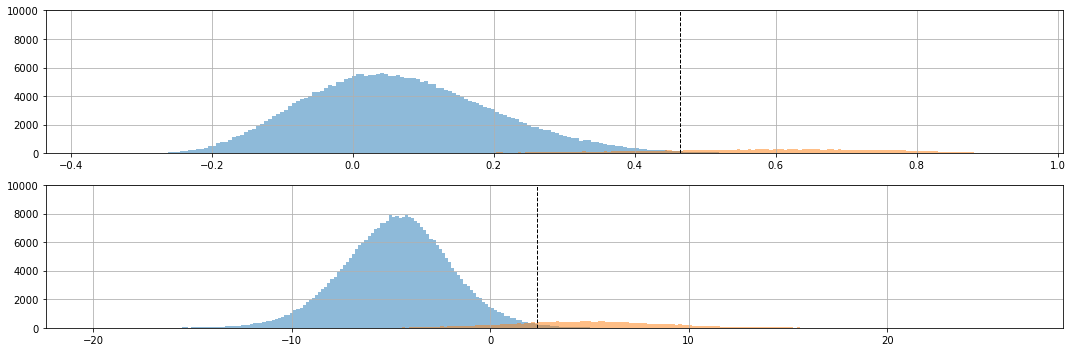

In [61]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
atnorm_s[atnorm_s.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
atnorm_s[atnorm_s.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [62]:
metrics['AT-Norm-S_enroll'] = {'EER': eer, 'minDCF': mindcf}

### 3.7 AS-Norm1

In [63]:
asnorm = S_Norm(trials_Z, aznorm_s, atnorm_t)
eer, thresh, fpr, tpr = calculate_eer(asnorm.label, asnorm.normalized_score, pos=1)
asnorm.to_pickle('./asnorm.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 6.85%


In [64]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(asnorm.normalized_score.reset_index(drop=True), 
                                           asnorm.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3423, at threshold 2.8082 (p-target=0.05, c-miss=1, c-fa=1)


In [65]:
# plt.figure(figsize=(10,8))
# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# asnorm[asnorm.label == 0]['normalized_score'].hist(bins=200)
# asnorm[asnorm.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-10,10);

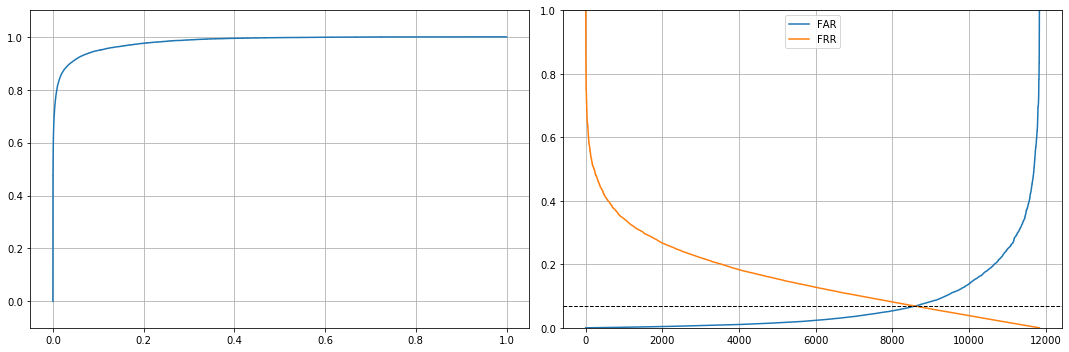

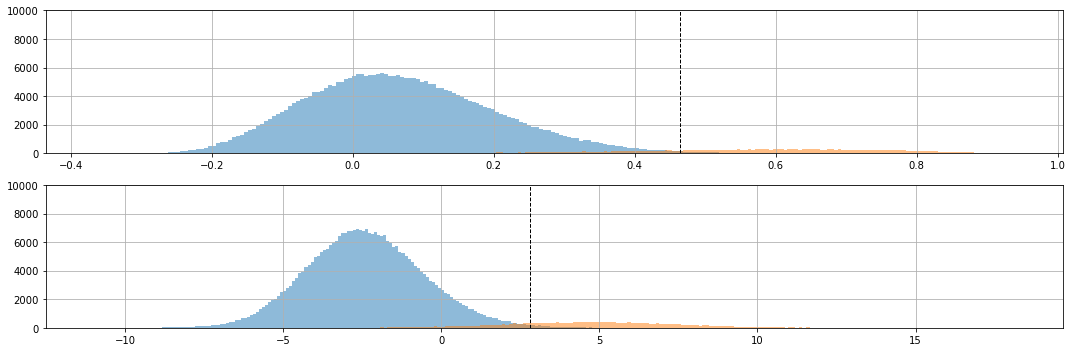

In [66]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
asnorm[asnorm.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
asnorm[asnorm.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [67]:
metrics['AS-Norm1'] = {'EER': eer, 'minDCF': mindcf}

### 3.8 AS-Norm2

voir https://pdfs.semanticscholar.org/295b/4823f8baa9b8c8b24ae7d28875344062731b.pdf

In [68]:
asnorm2 = S_Norm(trials_Z, aznorm_t, atnorm_s)
eer, thresh, fpr, tpr = calculate_eer(asnorm2.label, asnorm2.normalized_score, pos=1)
asnorm2.to_pickle('./asnorm2.pkl')
print('EER : %.2f%%'%(eer*100))

EER : 6.85%


In [69]:
c_miss = 1
c_fa = 1
p_target = 0.05

fnrs, fprs, thresholds = ComputeErrorRates(asnorm2.normalized_score.reset_index(drop=True), 
                                           asnorm2.label.reset_index(drop=True))
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3423, at threshold 2.8082 (p-target=0.05, c-miss=1, c-fa=1)


In [70]:
# plt.figure(figsize=(10,8))
# fig = plt.subplot(211)
# trials_Z[trials_Z.label == 0]['score'].hist(bins=200)
# trials_Z[trials_Z.label == 1]['score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-200,100);

# fig = plt.subplot(212)
# asnorm2[asnorm2.label == 0]['normalized_score'].hist(bins=200)
# asnorm2[asnorm2.label == 1]['normalized_score'].hist(bins=200)
# plt.ylim(0,10000);
# # plt.xlim(-10,10);

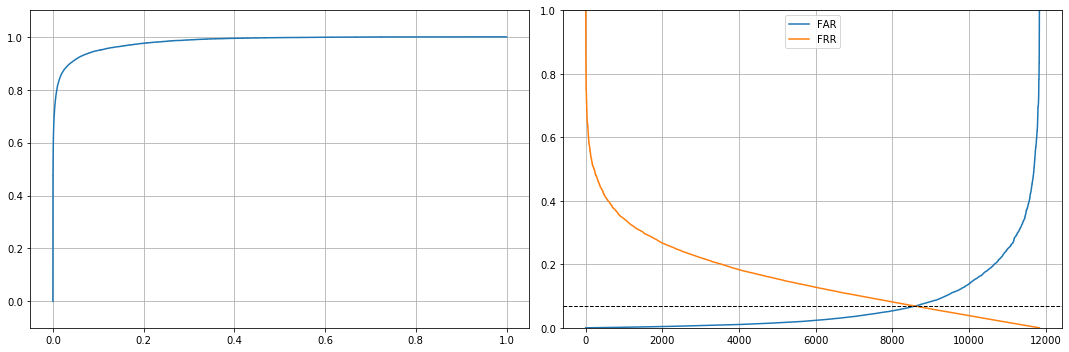

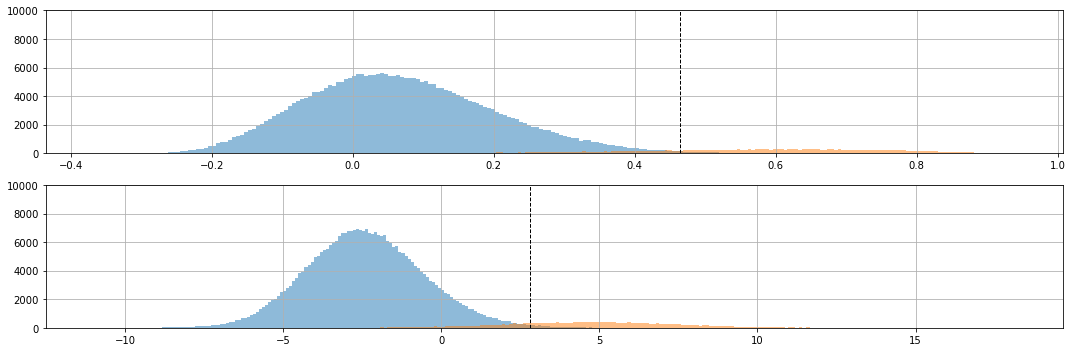

In [71]:
plt.figure(figsize=(15,5))
fig = plt.subplot(121)
plt.plot(fpr,tpr)
plt.grid()
# plt.xlim(0,1)
plt.ylim(-0.1,1.1)

fig = plt.subplot(122)
plt.plot(fpr, label='FAR') # FAR
plt.plot(1-tpr, label='FRR') # FRR
plt.axhline(eer, c='black', linestyle='--', lw=1)
plt.legend()
plt.grid()
# plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()

plt.figure(figsize=(15,5))
fig = plt.subplot(211)
trials_Z[trials_Z.label == 0]['score'].hist(bins=200, alpha=0.5)
trials_Z[trials_Z.label == 1]['score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold_default, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

fig = plt.subplot(212)
asnorm2[asnorm2.label == 0]['normalized_score'].hist(bins=200, alpha=0.5)
asnorm2[asnorm2.label == 1]['normalized_score'].hist(bins=200, alpha=0.5)
plt.axvline(x=threshold, c='black', linestyle='--', lw=1)
plt.ylim(0,10000)
# plt.xlim(0,1);
plt.tight_layout();

In [72]:
metrics['AS-Norm2'] = {'EER': eer, 'minDCF': mindcf}

### 4.0 Analysis

In [73]:
# Lowest minDCF
pd.DataFrame(metrics).T.sort_values('minDCF')[['minDCF']]

# Lowest EER
pd.DataFrame(metrics).T.sort_values('EER')[['EER']]*100

,minDCF
S-Norm,0.334643
No-Norm,0.338105
AS-Norm1,0.342323
AS-Norm2,0.342323
Z-Norm,0.343751
T-Norm,0.356903
AZ-Norm-T_enroll,0.362108
AT-Norm-t_enroll,0.362108
AZ-Norm-S_enroll,0.364243
AT-Norm-S_enroll,0.364243


,EER
AS-Norm1,6.848073
AS-Norm2,6.848073
No-Norm,6.922226
S-Norm,6.971758
AZ-Norm-S_enroll,6.983069
AT-Norm-S_enroll,6.983069
ZT-Norm,6.984127
AZ-Norm-T_enroll,7.029469
AT-Norm-t_enroll,7.029469
T-Norm,7.031162
